# Calculate average dx and average dy for video of cells

Computes a dense optical flow using the Gunnar Farneback’s algorithm:

Gunnar Farneback, Two-frame motion estimation based on polynomial expansion, Lecture Notes in Computer Science, 2003, (2749), , 363-370.


Units of velocity are, I believe, Pixels/Frame.

In [1]:
import os
import fnmatch

import cv2
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import seaborn as sns

%pylab inline
    
def get_optical_flow_at_each_time(video_filename="data/07062016"):
    """ Given a video filename, return dx's and dy's for each time point"""
    mean_dxs = []
    mean_dys = []

    cap = cv2.VideoCapture(video_filename)

    ret, frame1 = cap.read()

    prvs = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
    hsv = np.zeros_like(frame1)
    hsv[...,1] = 255

    while(True):
        ret, frame2 = cap.read()
        if not ret:
            break

        next = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)

        flow = cv2.calcOpticalFlowFarneback(prvs,next, None, 0.5, 3, 15, 3, 5, 1.2, 0)

        prvs = next

        dx, dy = np.reshape(np.swapaxes(flow,0,2), (2, -1))

        mean_dxs.append(np.mean(dx))
        mean_dys.append(np.mean(dy))

    return mean_dxs, mean_dys

def plot_histogram(xs, ys, ticksize=12, fontsize=16, show=True):
    """ Plot a histogram given a numeric vector"""
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    
    font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : fontsize}

    mpl.rc('font', **font)
    
    hist, bins = np.histogram(xs, bins=10)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    ax1.bar(center, hist, align='center', width=width)
    ax1.text(0.55, 0.8,"mean: %.3f" % np.mean(xs), horizontalalignment='left',
             verticalalignment='center', transform = ax1.transAxes)
    ax1.text(0.55, 0.72,"stdev: %.3f" % np.std(xs), horizontalalignment='left',
         verticalalignment='center', transform = ax1.transAxes)
    ax1.set_xlabel("delta x", fontsize=fontsize)
    ax1.set_ylabel("Frequency", fontsize=fontsize)
    ax2.tick_params(axis='both', which='major', labelsize=ticksize)
    
    hist, bins = np.histogram(ys, bins=10)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    ax2.bar(center, hist, align='center', width=width)
    ax2.text(0.55, 0.8,"mean: %.3f" % np.mean(ys), horizontalalignment='left',
             verticalalignment='center', transform = ax2.transAxes)
    ax2.text(0.55, 0.72,"stdev: %.3f" % np.std(ys), horizontalalignment='left',
         verticalalignment='center', transform = ax2.transAxes)
    ax2.set_xlabel("delta y", fontsize=fontsize)
    ax2.tick_params(axis='both', which='major', labelsize=ticksize)

    if show:
        plt.show()
    return f

Populating the interactive namespace from numpy and matplotlib


## Here is an example histogram

I've increased the font sizes and shown the mean and stdev of the distribution.

/home/ubuntu/Desktop/cell_motion/venv/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


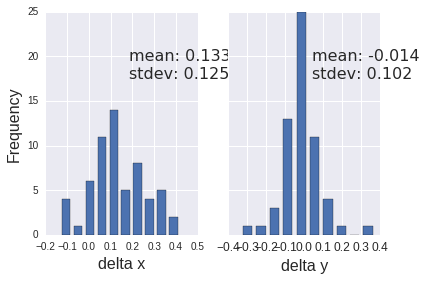

In [2]:
filepath = "data/07052016_Phagocytosis_DMSO.avi"
mean_dxs, mean_dys = get_optical_flow_at_each_time(filepath)
fig = plot_histogram(mean_dxs, mean_dys)

## Now lets calculate optical flow for each video and save histograms for each video

For each video.avi in `data/`, a corresponding histogram.png is plotted in `histograms/` with the same filename.

In [74]:
filenames = os.listdir("data/")
figure_format = ".png"

xs = []
ys = []
fnames = []
for filename in filenames:
    if fnmatch.fnmatch(filename, '*.avi'):
        mean_dxs, mean_dys = get_optical_flow_at_each_time("data/" + filename)
        xs.append(mean_dxs)
        ys.append(mean_dys)
        fnames.append(filename)
        fig = plot_histogram(mean_dxs, mean_dys, show=False)
        fig.savefig("histograms/" + os.path.splitext(filename)[0] + figure_format)
    
        print("Saved histogram for: ", filename)

## Now lets plot an set of 2d histograms/density-plots for easy viewing

the plots are in the same order as the list of files above:

- 07052016_Phagocytosis_DMSO.avi
- PMN_MSU_DMSO_08172016.avi
- 07072016_Phagocytosis_MRS2578.avi
- 07062016_Phagocytosis_MRS2578.avi
- MRS2578_08092016_Phagocytosis.avi
- PMN_MRS2578_08172016.avi
- DMSO_08092016_Phagocytosis.avi
- 07072016_Phagocytosis_DMSO.avi
- 07052016_Phagocytosis_MRS2578.avi
- 07062016_Phagocytosis_DMSO.avi
- Phagocytosis_06302016_dmso.avi
- Phagocytosis_Mrs2578_06302016.avi


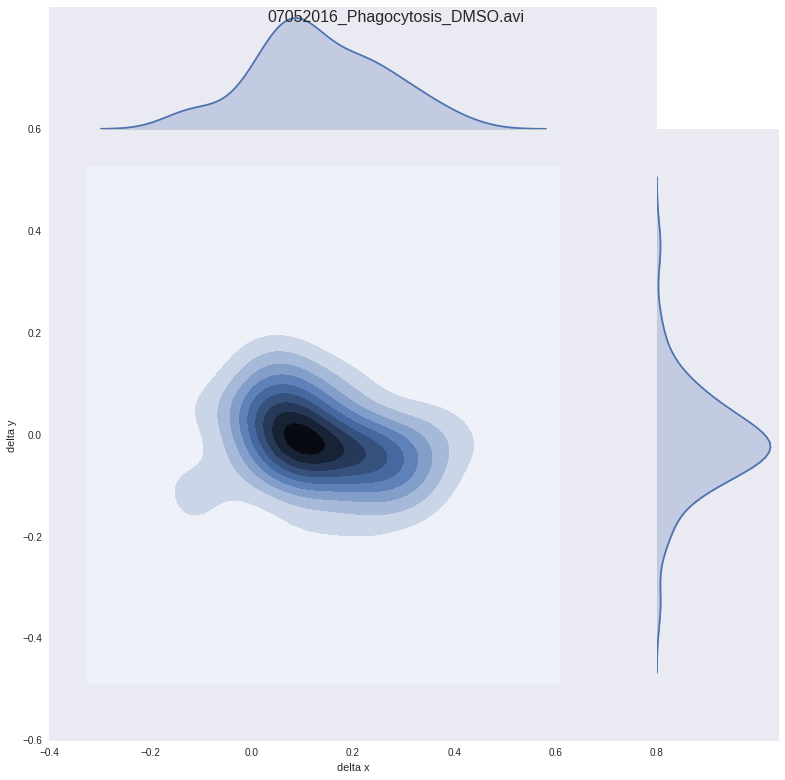

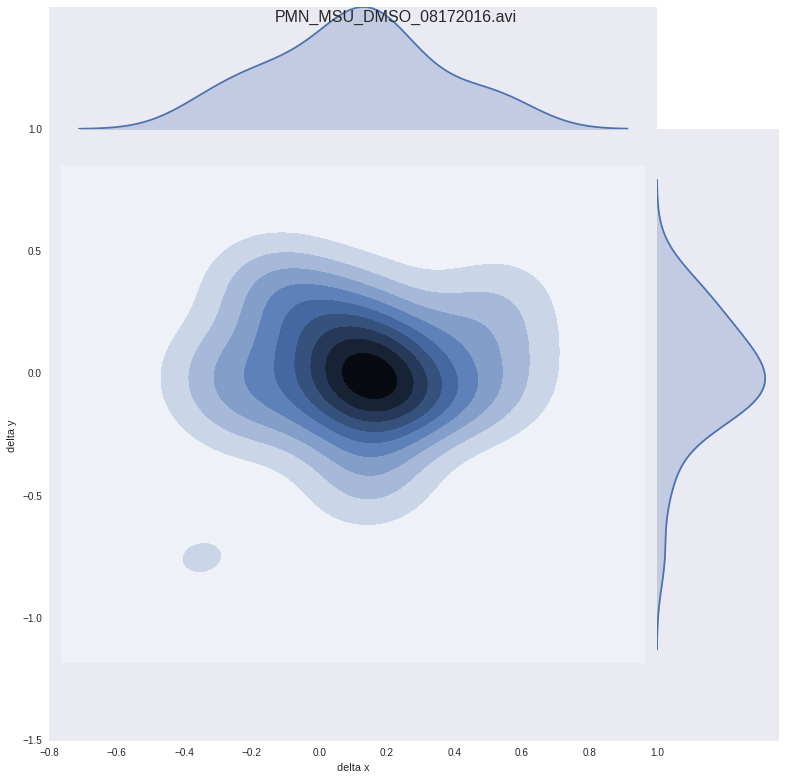

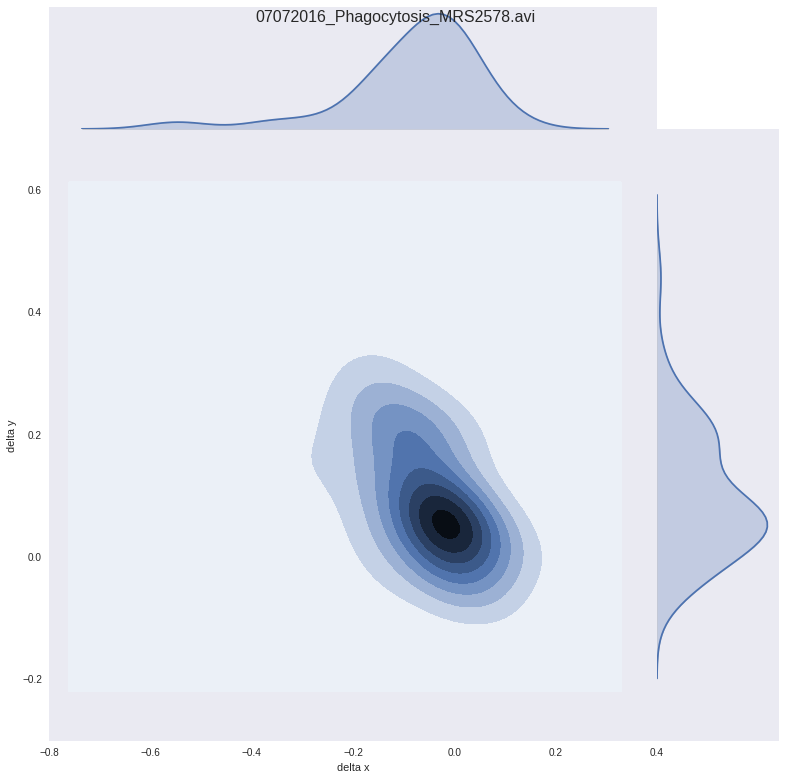

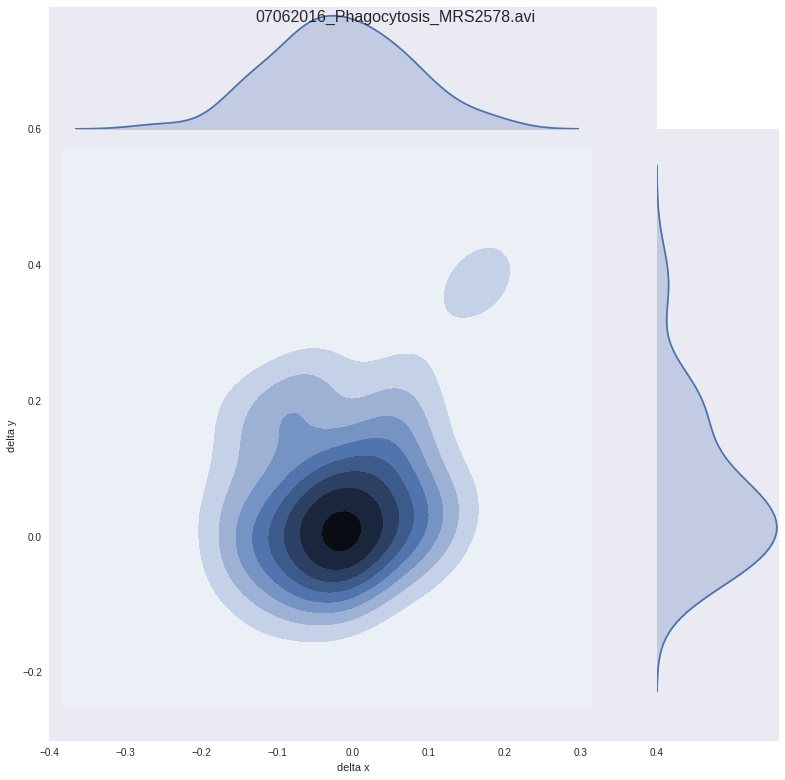

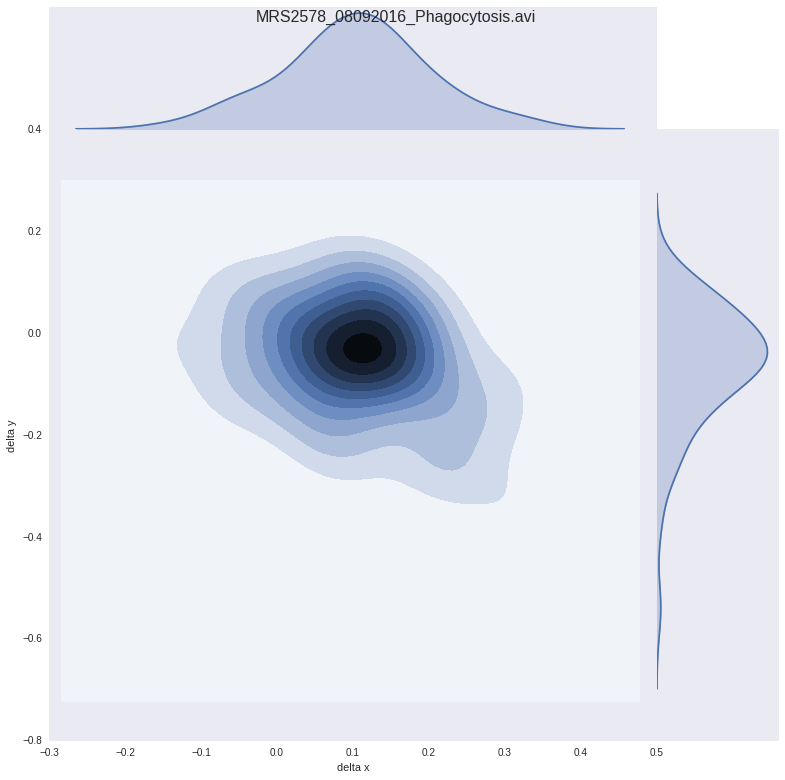

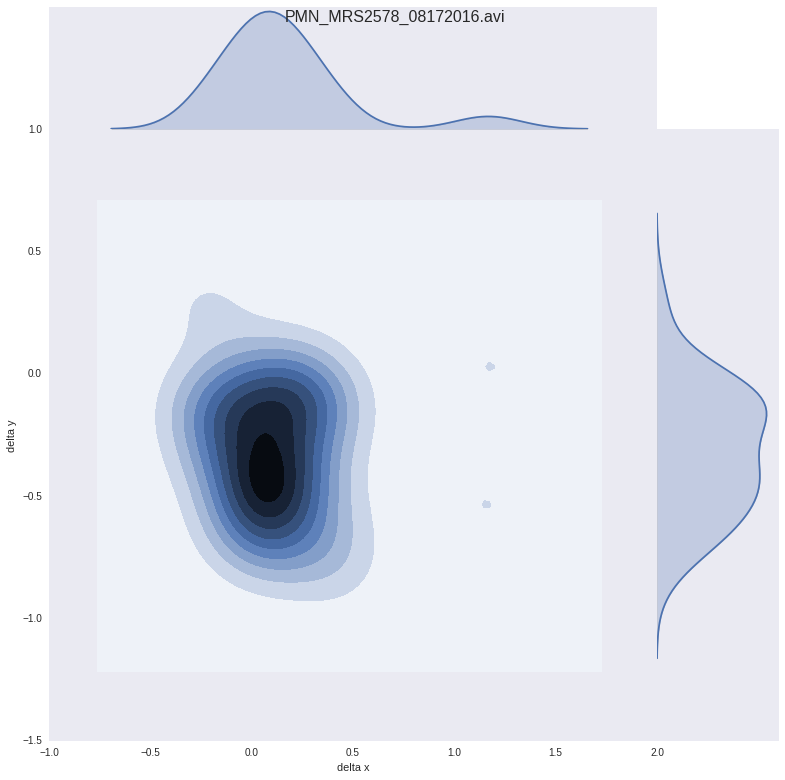

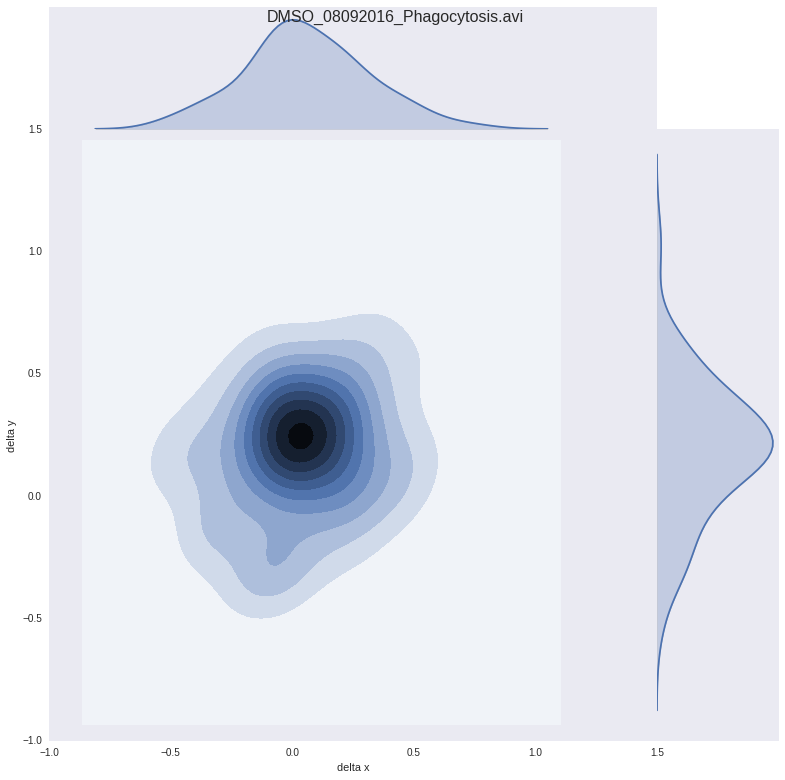

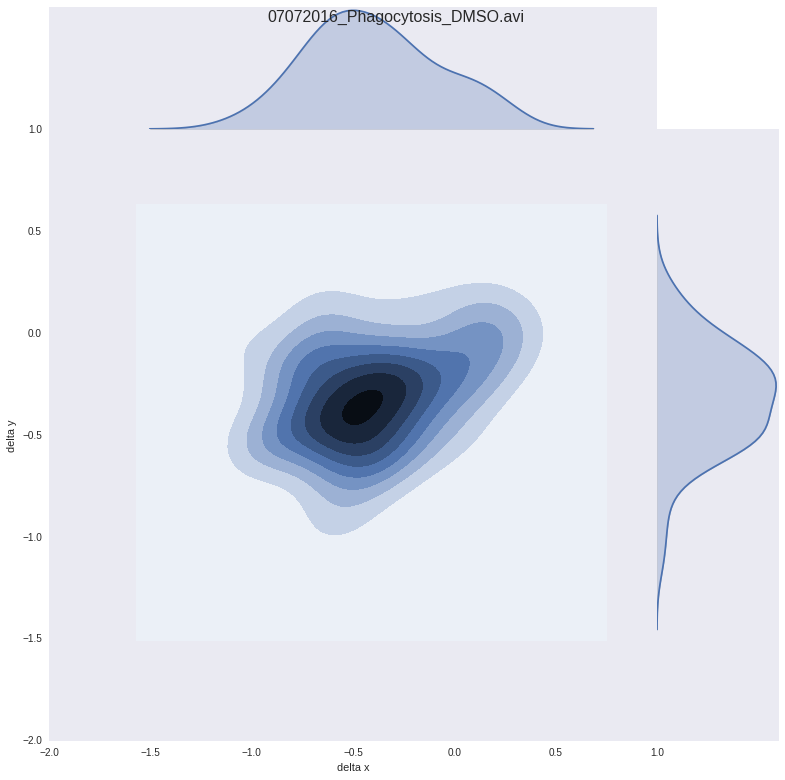

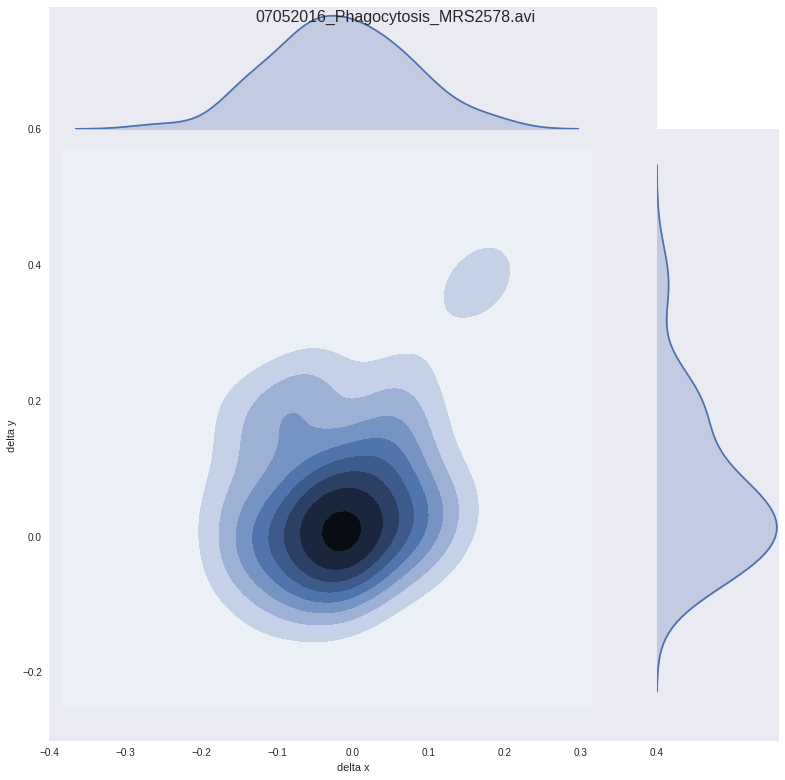

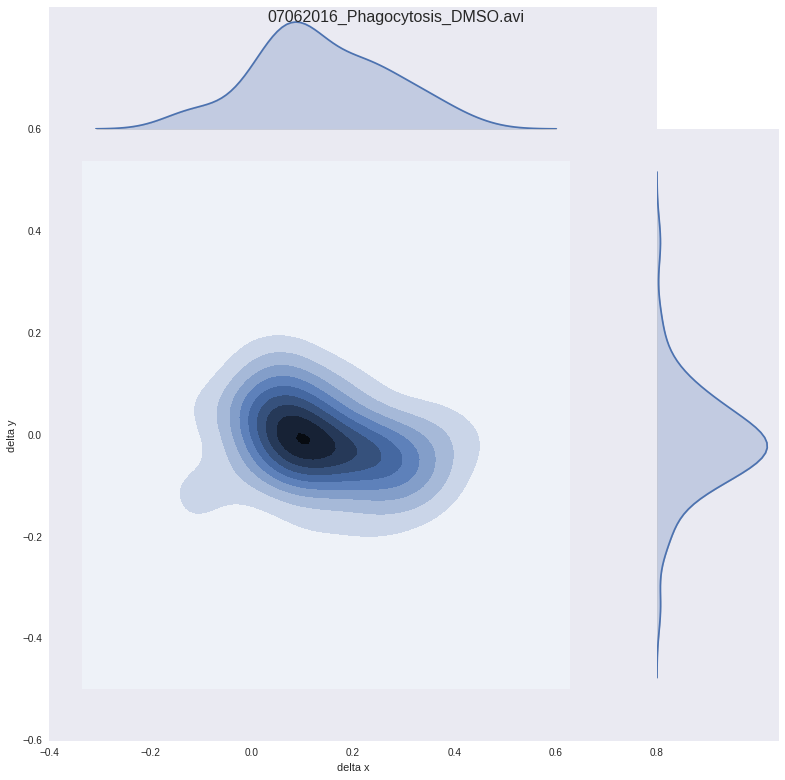

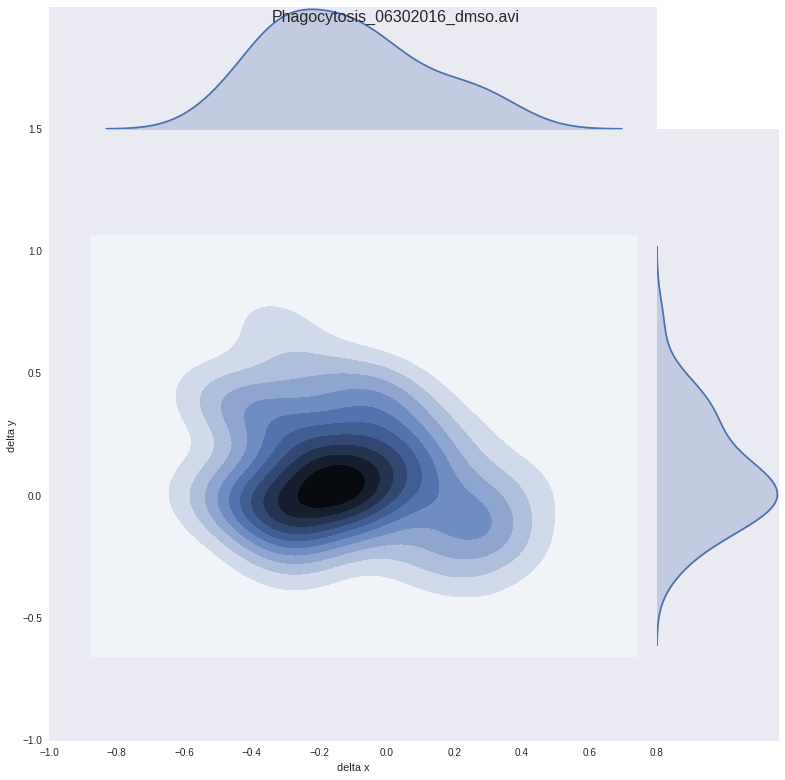

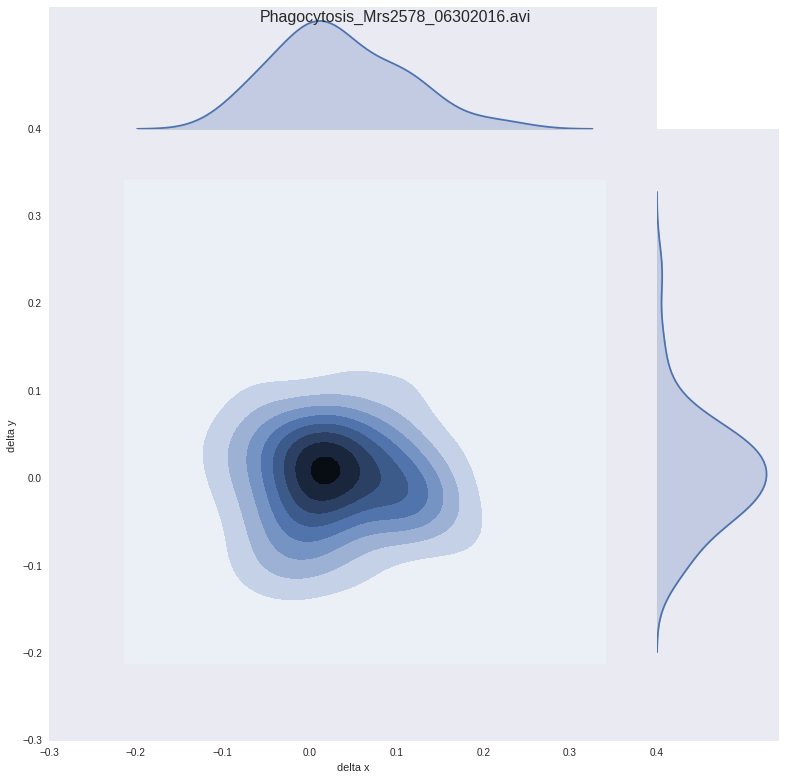

In [81]:
sns.set(style="dark")
import pandas as pd

for i in range(len(xs)):
    x = pd.Series(np.array(xs[i]), name="delta x")
    y = pd.Series(np.array(ys[i]), name="delta y")
    title = fnames[i]
    g = sns.jointplot(x, y, kind="kde", stat_func=None, size=11, space=0)
    g.fig.suptitle(title, size=16)